# The downstream tracking study based on sklearn framework.
## Study of the T-seed selection using BDT classifier

This script contains all of my study based on **BDT - GradientBoostedClassifier**.

## Study roadmap 
--------------
1. Train  the first version of Gradient Boosted Classifer with default parameters and without any features engeenering. Just to know baseline score. 
2. Add basic features transforamtion eg. pseudorapidity and abs. 
3. Tune hiperparameters at first number of trees and learining rate 
4. Add linear combination and features's ratios
5. Speedup the algorithm using idea of [bonsai Decision Trees](http://arxiv.org/pdf/1210.6861v1.pdf)  
   I will use implementation of bBDT from [hep_ml](https://github.com/arogozhnikov/hep_ml/blob/master/hep_ml/speedup.py). 
 


In [1]:
print ("kernel is alive!")

kernel is alive!


In [2]:
import root_numpy
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

#sklearn imports 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import grid_search
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.externals import joblib

from hep_ml.speedup import LookupClassifier

Welcome to ROOTaaS 6.06/02


### As a very first step I need to grab training data form the NTpule. 
To obtain this goal I will use **root_numpy**, that allows me to convert root NTuple to pandas.Dataframe

In [3]:
root_file = ROOT.TFile("datasets/Brunel_test_30kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)
data.head()

,is_true_seed,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,False,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572
1,False,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081
2,False,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975
3,False,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753
4,True,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980


### Print the features distributions

I want to know how doest the features looks like.

In [5]:
features.describe()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
count,2820225.000000,2.820225e+06,2.820225e+06,2820225.000000,2820225.000000,2820225.000000,2820225.000000,2820225.000000,2820225.000000,2820225.000000
mean,2.151541,2.597007e+04,2.154239e+03,17.786964,2.583371,11.168504,2.711442,-6.605598,0.003993,-0.000770
std,1.450411,3.971438e+06,1.839172e+05,4.672981,4.624577,1.080491,695.398805,562.730757,0.319859,0.073198
min,0.000250,1.112569e+03,1.762072e+00,8.000000,0.000000,8.000000,-2491.031005,-2277.240338,-1.284890,-1.225459
25%,1.053873,3.014385e+03,9.318066e+02,13.000000,0.000000,11.000000,-395.587195,-222.158379,-0.179371,-0.031975
50%,1.714204,5.749199e+03,1.123466e+03,19.000000,0.000000,12.000000,-4.058384,-4.284824,0.004472,-0.000420
75%,2.949078,1.318862e+04,1.370916e+03,22.000000,4.000000,12.000000,399.664220,209.894007,0.190217,0.030538
max,8.999829,4.048456e+09,1.676033e+08,32.000000,23.000000,12.000000,2505.840240,2217.239114,1.358254,0.594471


In [6]:
def print_features_histograms(features, target):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 5 + 1, 6, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = numpy.percentile(features[feature], [1, 99])
        ax.hist(features.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='ghost', **hist_params)
        ax.hist(features.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='true', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

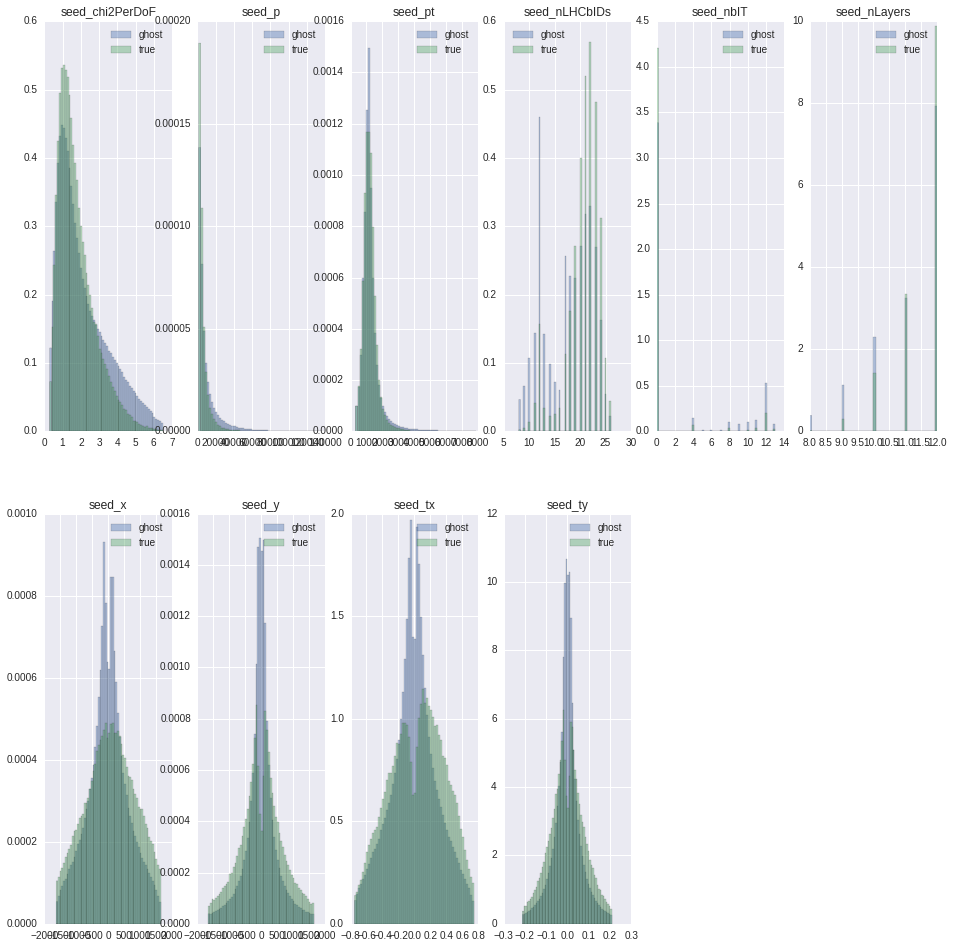

In [6]:
print_features_histograms(features, data.is_true_seed)

In [7]:
def feature_boxplot(features):
    for n, feature in enumerate(features):
    # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 5 + 1, 6, n + 1)
        data.boxplot(feature,by='is_true_seed', ax=ax, whis='range');
        ax.legend(loc='best')      

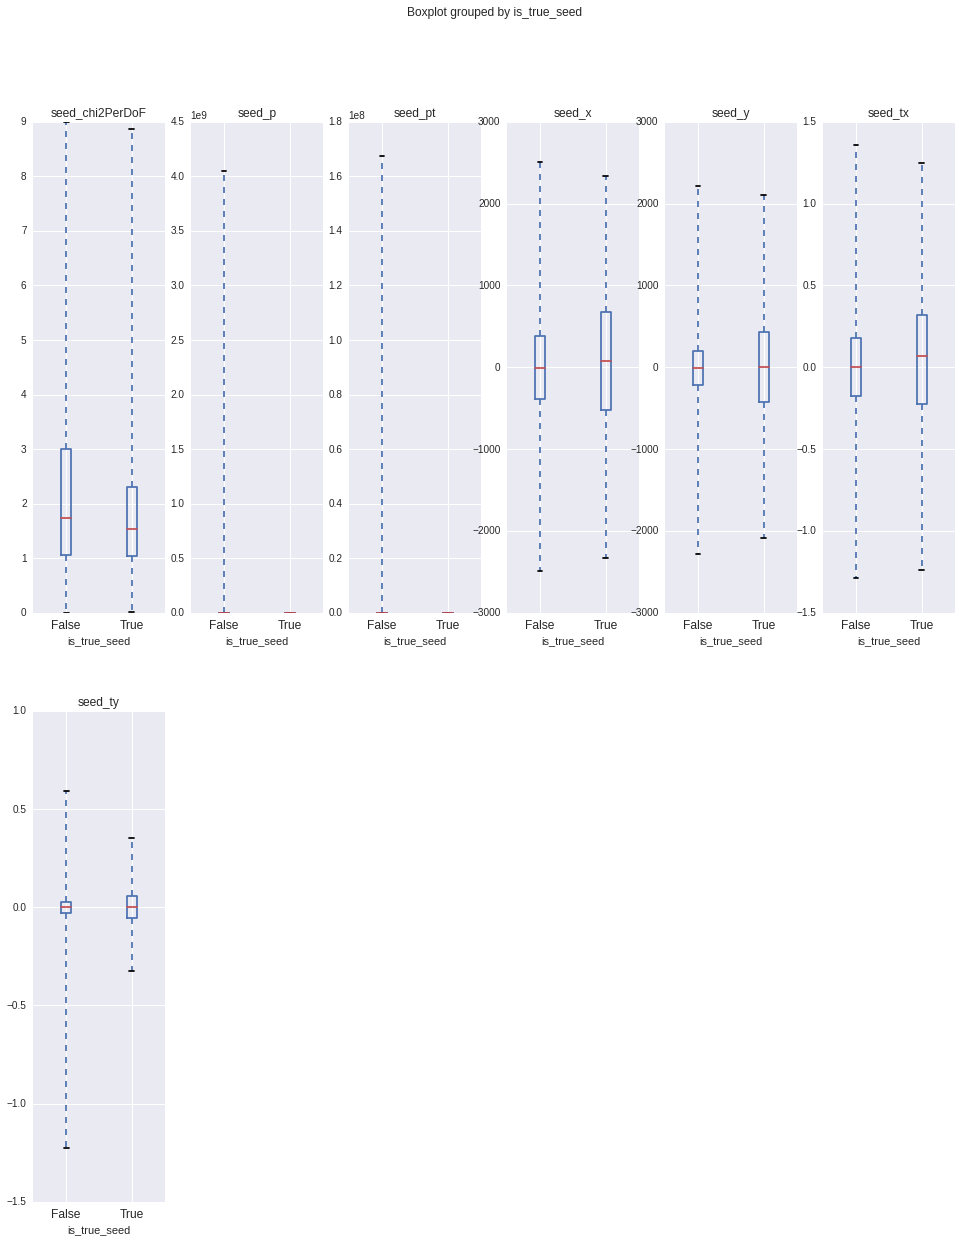

In [8]:
fig = plt.figure(figsize=(16,  20))
real_data_features = features.drop(['seed_nbIT','seed_nLHCbIDs', 'seed_nbIT','seed_nLayers' ],axis=1)
feature_boxplot(real_data_features)

In [19]:
def pairplot(data, vars):
    sns.pairplot(data, hue="is_true_seed", vars=vars, plot_kws={'alpha': 0.5, 'marker': '.'})


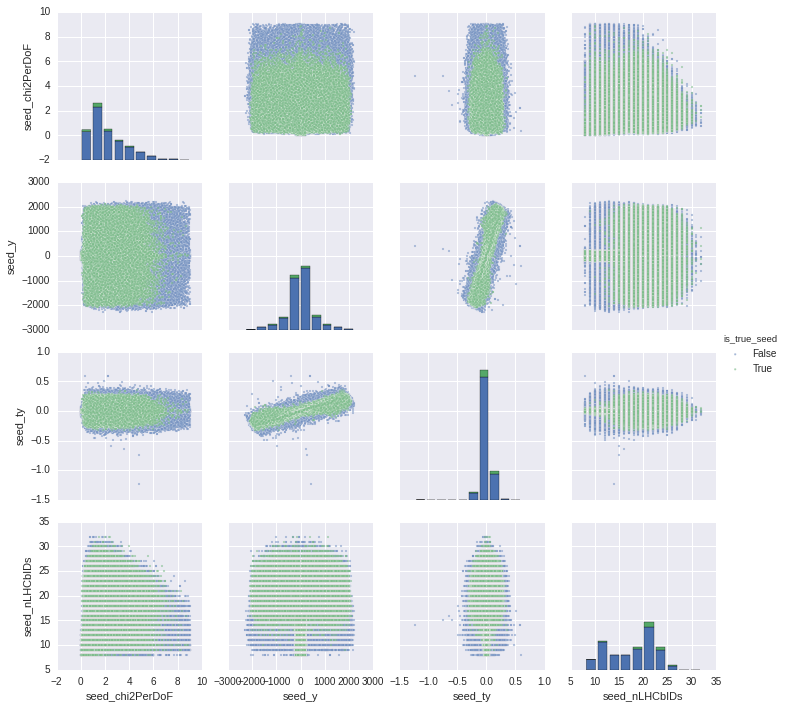

In [23]:
vars = ["seed_chi2PerDoF","seed_y","seed_ty","seed_nLHCbIDs"]
pairplot(data, vars)

## Training of the baseline clasifiers
The aim of this step is to find a BDT score without any tuning of the hyperparameters.   
I use sudo-default set of parameters. I also want to build the tools for further usage. 

Split data into train and validation sets
----------------------

In [8]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.5 )

Boosted Decision Tree clasifier
------------------------------
The above plots present's performance of the BDT. It is one of the best classifier, that can be used as a baseline. 

In [10]:
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=13,
                                min_samples_leaf=100, max_depth=6, max_features=8, verbose = 3 )
gb.fit(trainX,trainY)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.4615           0.0103          101.59m
         2           0.4538           0.0077           91.13m
         3           0.4477           0.0059           86.79m
         4           0.4417           0.0050           85.37m
         5           0.4380           0.0043           84.68m
         6           0.4343           0.0035           85.10m
         7           0.4321           0.0031           84.89m
         8           0.4278           0.0028           84.20m
         9           0.4263           0.0021           83.64m
        10           0.4242           0.0020           83.60m
        11           0.4220           0.0019           83.34m
        12           0.4207           0.0014           82.68m
        13           0.4193           0.0014           81.85m
        14           0.4186           0.0014           81.22m
        15           0.4171           0.0012           80.83m
       

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=8, max_leaf_nodes=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              random_state=13, subsample=0.8, verbose=3, warm_start=False)

In [11]:
print "ROC AUC score"
roc_auc_score(testY, gb.predict_proba(testX)[:, 1])

ROC AUC score


0.81049367142781981

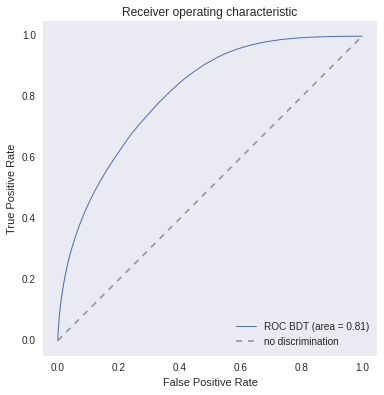

In [12]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(testY, gb.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Check importance of the features based on the BDT. 

In [13]:
def print_feature_importance(model, features):
    importances = model.feature_importances_
    std = numpy.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = numpy.argsort(importances)[::-1]
    features_names =  list(features.columns.values)

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(features.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, features_names[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(features.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(features.shape[1]), features_names, rotation=70)
    plt.xlim([-1, features.shape[1]])
    plt.show()

Feature ranking:
1. feature seed_chi2PerDoF (0.202014)
2. feature seed_p (0.157784)
3. feature seed_pt (0.136610)
4. feature seed_nLHCbIDs (0.111800)
5. feature seed_nbIT (0.095766)
6. feature seed_nLayers (0.092257)
7. feature seed_x (0.092235)
8. feature seed_y (0.087928)
9. feature seed_tx (0.017259)
10. feature seed_ty (0.006347)


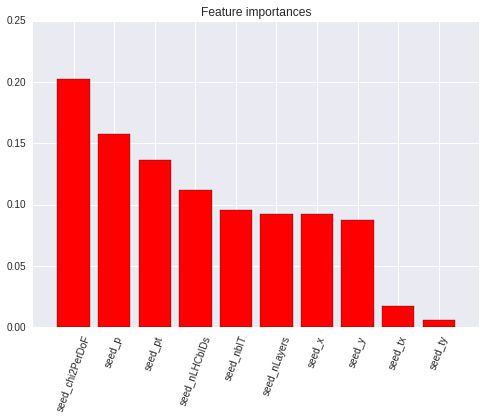

In [14]:
print_feature_importance(gb, features)

In [16]:
probas = gb.staged_predict_proba(testX)
tree_scores = [] 
for proba in probas:
    predicted = proba[:, 1]
    score =  roc_auc_score(testY, predicted)
    tree_scores.append(score)

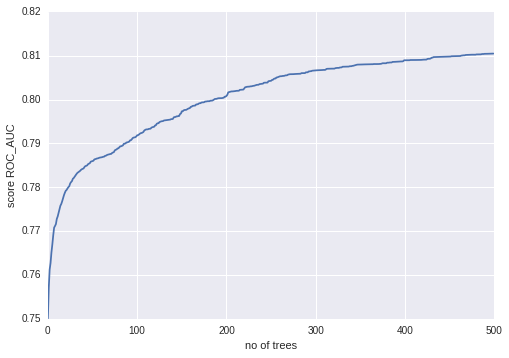

In [18]:
x = numpy.array([x  for x in range(500)])
plt.figure()
plt.plot(x,tree_scores)
plt.ylim(0.75, 0.82)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

# Feature Engenering

## Add transformated features

At the begining let's try some very basic feature transformation. 
I also add pseudorapidity and seed_r

In [4]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=numpy.abs(data['seed_x'])
    out["abs_seed_y"]=numpy.abs(data['seed_y'])
    out["abs_seed_tx"]=numpy.abs(data['seed_tx'])
    out["abs_seed_ty"]=numpy.abs(data['seed_ty'])
    out['seed_r'] = numpy.sqrt(numpy.square(data.seed_x) +numpy.square(data.seed_y))    
    out['pseudo_rapidity'] = numpy.arctanh(data.seed_pt/data.seed_p)
    return out

In [5]:
new_data = basic_transforamtion(data)
new_features = new_data.drop("is_true_seed", axis=1).astype(numpy.float64)
new_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572,1263.157617,517.249191,0.524220,0.061572,1364.959300,0.505958
1,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081,1264.522435,99.363473,0.480288,0.009081,1268.420312,0.463589
2,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975,1521.093160,196.064807,0.382802,0.025975,1533.677219,0.374842
3,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753,1563.145597,483.850246,0.369674,0.058753,1636.317578,0.366082
4,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980,1641.727752,411.084316,0.646627,0.054980,1692.412576,0.610352


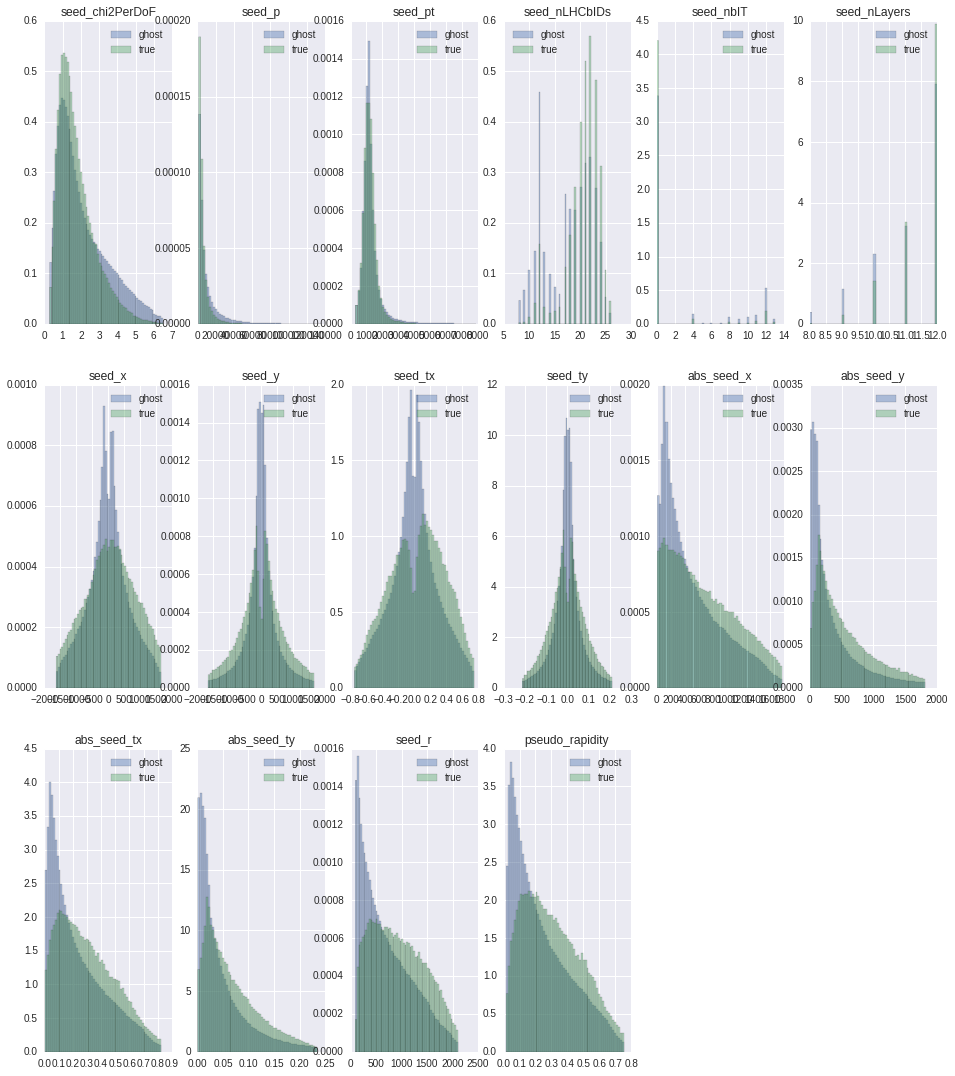

In [23]:
print_features_histograms(new_features, target)

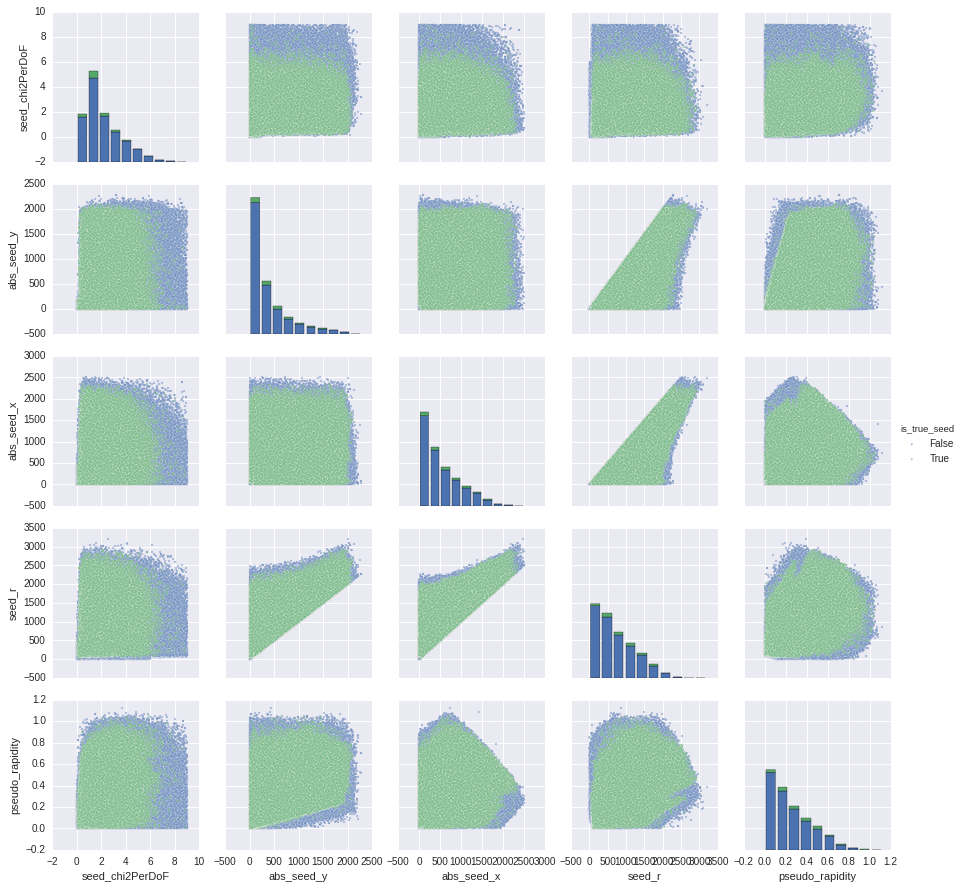

In [59]:
vars = ["seed_chi2PerDoF","abs_seed_y","abs_seed_x","seed_r","pseudo_rapidity"]
pairplot(data, vars)

In [24]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.5 )

In [26]:
gb2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=600, subsample=0.8, random_state=13,
                                min_samples_leaf=100, max_depth=6, max_features=8, verbose = 3 )
gb2.fit(new_trainX,new_trainY)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.4615           0.0103          142.42m
         2           0.4534           0.0080          124.13m
         3           0.4464           0.0067          118.61m
         4           0.4402           0.0054          114.47m
         5           0.4362           0.0045          111.41m
         6           0.4323           0.0039          111.76m
         7           0.4301           0.0031          109.46m
         8           0.4257           0.0028          108.49m
         9           0.4237           0.0026          107.95m
        10           0.4214           0.0022          107.23m
        11           0.4192           0.0019          106.32m
        12           0.4177           0.0017          105.28m
        13           0.4162           0.0015          105.10m
        14           0.4155           0.0014          104.33m
        15           0.4140           0.0011          104.00m
       

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=8, max_leaf_nodes=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              random_state=13, subsample=0.8, verbose=3, warm_start=False)

In [27]:
roc_auc_score(new_testY, gb2.predict_proba(new_testX)[:, 1])

0.81509812475535492

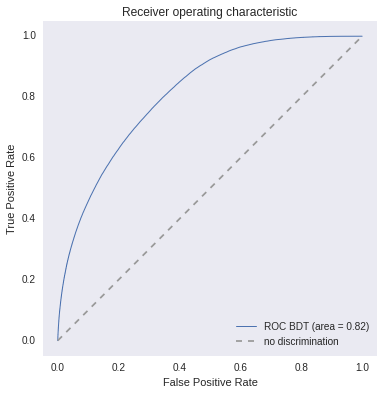

In [30]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Feature ranking:
1. feature seed_chi2PerDoF (0.112631)
2. feature seed_p (0.110137)
3. feature seed_pt (0.099640)
4. feature seed_nLHCbIDs (0.073631)
5. feature seed_nbIT (0.073501)
6. feature seed_nLayers (0.072903)
7. feature seed_x (0.064276)
8. feature seed_y (0.061122)
9. feature seed_tx (0.056240)
10. feature seed_ty (0.055529)
11. feature abs_seed_x (0.051381)
12. feature abs_seed_y (0.050432)
13. feature abs_seed_tx (0.049206)
14. feature abs_seed_ty (0.045271)
15. feature seed_r (0.019360)
16. feature pseudo_rapidity (0.004738)


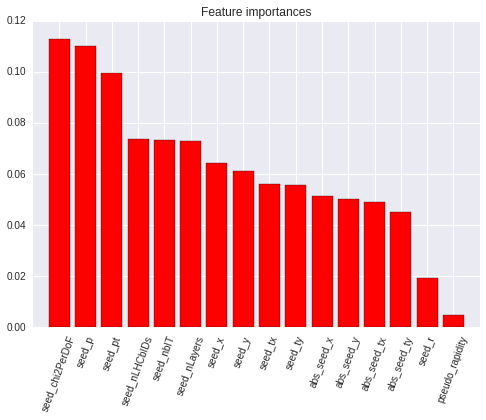

In [29]:
print_feature_importance(gb2, new_features)

In [37]:
probas2 = gb2.staged_predict_proba(new_testX)
tree_scores2 = [] 
for proba in probas2:
    predicted = proba[:, 1]
    score =  roc_auc_score(new_testY, predicted)
    tree_scores2.append(score)

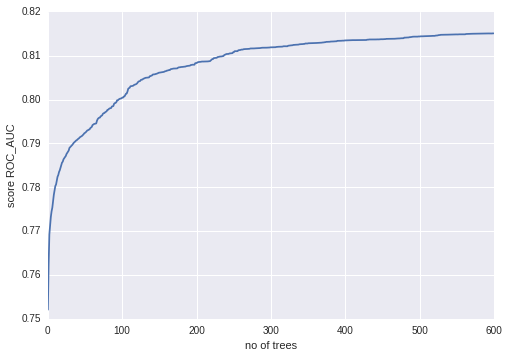

In [39]:
x = numpy.array([x  for x in range(600)])
plt.figure()
plt.plot(x,tree_scores2)
plt.ylim(0.75, 0.82)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

## Hyperparameters optimalization

I perform following steps to tune the hyperparameters for a gradient boosting model:

1. Choose loss based on your problem at hand (ie. target metric)
2. Pick n_estimators as large as (computationally) possible (e.g. 600).
3. Tune max_depth, learning_rate, min_samples_leaf, and max_features via grid search.
4. Increase n_estimators even more and tune learning_rate again holding the other parameters fixed.
Scikit-learn provides a convenient API for hyperparameter tuning and grid search. 


In [48]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6, 8],
              'min_samples_leaf': [20, 50,100,150],
              #'max_features': [1.0, 0.3, 0.1] 
              }
print(gb_grid_params)

gb_gs = GradientBoostingClassifier(n_estimators = 600)

clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=2,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=10);
clf.fit(train_gs_X, train_gs_Y);

{'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [4, 6, 8], 'min_samples_leaf': [5, 10, 20, 50]}
Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=5 ..............
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=5 ..............
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=10 .............
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=10 .............
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20 .............
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20 .............
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=50 .............
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=50 .............
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=5 ..............
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=5 ..............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=5, score=0.792508 -14.2min


[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed: 14.2min


[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=10 .............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.792306 -14.7min
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=10 .............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.793492 -14.7min
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=20 .............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, score=0.794283 -15.8min
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=20 .............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=10, score=0.792141 -15.9min
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=50 .............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=5, score=0.792764 -16.1min
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=50 .............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, score=0.793673 -16.3min
[CV] learning_rate=0.1, max_depth=8, min_samples_leaf=5 ..............
[CV]  

[Parallel(n_jobs=10)]: Done  32 jobs       | elapsed: 75.8min


[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=5 .............
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=5, score=0.795899 -24.4min
[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=10 ............
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=5, score=0.793854 -21.1min
[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=10 ............
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=10, score=0.797406 -22.9min
[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=20 ............
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=50, score=0.797479 -22.8min
[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=20 ............
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=10, score=0.796358 -25.3min
[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=50 ............
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=50, score=0.796989 -24.6min
[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=50 ............
[

[Parallel(n_jobs=10)]: Done  78 out of  96 | elapsed: 190.9min remaining: 44.1min


[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=50 ............
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=50, score=0.782077 -16.0min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=5 .............
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=50, score=0.782048 -16.8min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=5 .............
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=5, score=0.789573 -25.6min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=10 ............
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=20, score=0.789954 -25.4min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=10 ............
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=10, score=0.789876 -26.3min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=20 ............
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=10, score=0.789944 -26.9min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=20 ............


[Parallel(n_jobs=10)]: Done  96 out of  96 | elapsed: 243.2min finished


In [49]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 50}
Grid scores on development set:
0.793 (+/-0.000) for {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 5}
0.791 (+/-0.002) for {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 10}
0.794 (+/-0.001) for {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20}
0.793 (+/-0.001) for {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 50}
0.791 (+/-0.001) for {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 5}
0.793 (+/-0.001) for {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 10}
0.792 (+/-0.004) for {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 20}
0.795 (+/-0.003) for {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 50}
0.786 (+/-0.002) for {'learning_rate': 0.1, 'max_depth': 8, 'min_samples_leaf': 5}
0.786 (+/-0.002) for {'learning_rate': 0.1, 'max_depth': 8, 'min_samples_leaf': 10}
0.787 (+/-0.004) for 

In [10]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6, 8],
              'min_samples_leaf': [20, 50,100,150],
              #'max_features': [1.0, 0.3, 0.1] 
              }
print(gb_grid_params)

gb_gs = GradientBoostingClassifier(n_estimators = 600, max_features=8, subsample=0.8)

clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=2,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=10);
clf.fit(train_gs_X, train_gs_Y);

{'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [4, 6, 8], 'min_samples_leaf': [20, 50, 100, 150]}
Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20 .............
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20 .............
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=50 .............
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=50 .............
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=100 ............
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=100 ............
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=150 ............
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=150 ............
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=20 .............
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=20 .............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=150, score=0.794324 - 6.9min
[CV] learning_rate=0.1, max_depth=6, m

[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:  7.4min


[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, score=0.794969 - 7.3min
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=100 ............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=100, score=0.796047 - 7.3min
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=150 ............
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=150 ............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.793937 - 7.5min
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=100, score=0.794363 - 7.5min
[CV] learning_rate=0.1, max_depth=8, min_samples_leaf=20 .............
[CV] learning_rate=0.1, max_depth=8, min_samples_leaf=20 .............
[CV]  learning_rate=0.1, max_depth=6, min_samples_leaf=20, score=0.793246 -11.4min
[CV] learning_rate=0.1, max_depth=8, min_samples_leaf=50 .............
[CV]  learning_rate=0.1, max_depth=6, min_samples_leaf=20, score=0.792519 -11.6min
[CV] learning_rate=0.1, max_depth=8, min_samples_leaf=50 .............
[CV

[Parallel(n_jobs=10)]: Done  32 jobs       | elapsed: 36.0min


[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=20 ............
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=150, score=0.791750 - 8.4min
[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=20 ............
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=20, score=0.797206 -12.7min
[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=50 ............
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=20, score=0.798586 -12.8min
[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=50 ............
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=50, score=0.797600 -11.9min
[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=100 ...........
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=100, score=0.799658 -12.0min
[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=100 ...........
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=50, score=0.798895 -12.7min
[CV] learning_rate=0.05, max_depth=8, min_samples_leaf=150 .........

[Parallel(n_jobs=10)]: Done  78 out of  96 | elapsed: 96.2min remaining: 22.2min


[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=150 ...........
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=150, score=0.782638 - 7.8min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=20 ............
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=150, score=0.782364 - 8.1min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=20 ............
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=50, score=0.791464 -11.6min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=50 ............
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=50, score=0.791184 -12.5min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=50 ............
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=20, score=0.790920 -12.6min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=100 ...........
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=100, score=0.791640 -12.1min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=100 ........

[Parallel(n_jobs=10)]: Done  96 out of  96 | elapsed: 118.8min finished

tab completion not implemented for this context

tab completion not implemented for this context


## Train the new model
I use obtained parameters. 

* n_estimators 600 (wiil be increased depend on learning curve)
* learning rate 0.05
* min sample leaf  100 
* max depth 6

In [6]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.5 )
gb2 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=600, subsample=0.8, random_state=13,
                                min_samples_leaf=100, max_depth=8, max_features=8, verbose = 3 )
gb2.fit(new_trainX,new_trainY)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.4656           0.0061          280.18m
         2           0.4600           0.0056          250.89m
         3           0.4550           0.0048          251.77m
         4           0.4495           0.0044          248.53m
         5           0.4462           0.0038          247.65m
         6           0.4428           0.0034          243.18m
         7           0.4405           0.0030          242.98m
         8           0.4362           0.0029          242.33m
         9           0.4340           0.0027          243.94m
        10           0.4314           0.0024          242.38m
        11           0.4289           0.0023          240.40m
        12           0.4269           0.0020          239.61m
        13           0.4251           0.0019          238.05m
        14           0.4239           0.0018          236.37m
        15           0.4219           0.0016          235.47m
       

GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=8, max_features=8, max_leaf_nodes=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              random_state=13, subsample=0.8, verbose=3, warm_start=False)

In [7]:
print "ROC AUC score"
roc_auc_score(new_testY, gb2.predict_proba(new_testX)[:, 1])

ROC AUC score


0.81930587972460966

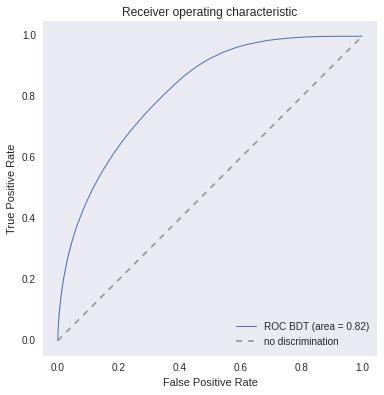

In [8]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Save model to file 
-------
It is a good idea to save BDT parameters to file for further study.  
I use **sklearn.externals.joblib**. According to the documentation is more effitient than pickle. 

In [9]:
joblib.dump(gb2, 'models/BDT.pkl') 

['models/BDT.pkl',
 'models/BDT.pkl_01.npy',
 'models/BDT.pkl_02.npy',
 'models/BDT.pkl_03.npy',
 'models/BDT.pkl_04.npy']

In [11]:
probas = gb2.staged_predict_proba(new_testX)
linear_tree_scores = [] 
for proba in probas:
    predicted = proba[:, 1]
    score =  roc_auc_score(new_testY, predicted)
    linear_tree_scores.append(score)

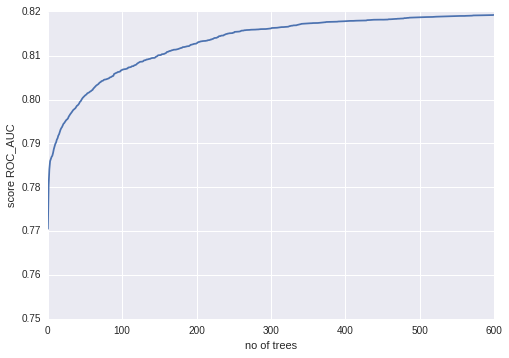

In [12]:
x = numpy.array([x  for x in range(600)])
plt.figure()
plt.plot(x,linear_tree_scores)
plt.ylim(0.75, 0.82)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Conclusions
--------
I try to add more features I will use as a number of trees = 150 for further study.  
To get the best, final  result I need to use about 400 trees. 

Add linear combination and ratios of the features
-----------

As a very first step I add such features as 
* number of cluster minus number of layers
* divide -||- 
* pseudo rapidity, momentum and transverse momentum divided by chi2 
* number of hit in OT

And then I will try to find importance of it. 

In [36]:
def add_more_transformations(data):
    out = data
    out["seed_lhcbId-layers"] = data.seed_nLHCbIDs - data.seed_nLayers
    out["seed_ot"] = data.seed_nLHCbIDs - data.seed_nbIT
    out["seed_pr/chi2"] = data.pseudo_rapidity / data.seed_chi2PerDoF
    out["seed_p/chi2"] = data.seed_p/ data.seed_chi2PerDoF
    out["seed_tr"]= numpy.sqrt(numpy.square(data.seed_tx) +numpy.square(data.seed_ty))    
    return out

In [40]:
linear_data = add_more_transformations(new_data)
linear_features = linear_data.drop("is_true_seed", axis=1).astype(numpy.float64)
linear_data.head()

,is_true_seed,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,...,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity,seed_lhcbId-layers,seed_pr/chi2,seed_p/chi2,seed_pt/chi2,seed_ot,seed_tr
0,False,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,...,0.524220,0.061572,1364.959300,0.505958,13,0.416870,2095.620933,978.215388,25,0.527823
1,False,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,...,0.480288,0.009081,1268.420312,0.463589,13,0.344391,2066.311262,894.722891,25,0.480374
2,False,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,...,0.382802,0.025975,1533.677219,0.374842,13,0.230299,2930.298550,1049.691701,25,0.383682
3,False,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,...,0.369674,0.058753,1636.317578,0.366082,13,0.204603,2907.907705,1019.396800,25,0.374314
4,True,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,...,0.646627,0.054980,1692.412576,0.610352,12,0.480881,1812.867601,986.879812,24,0.648960


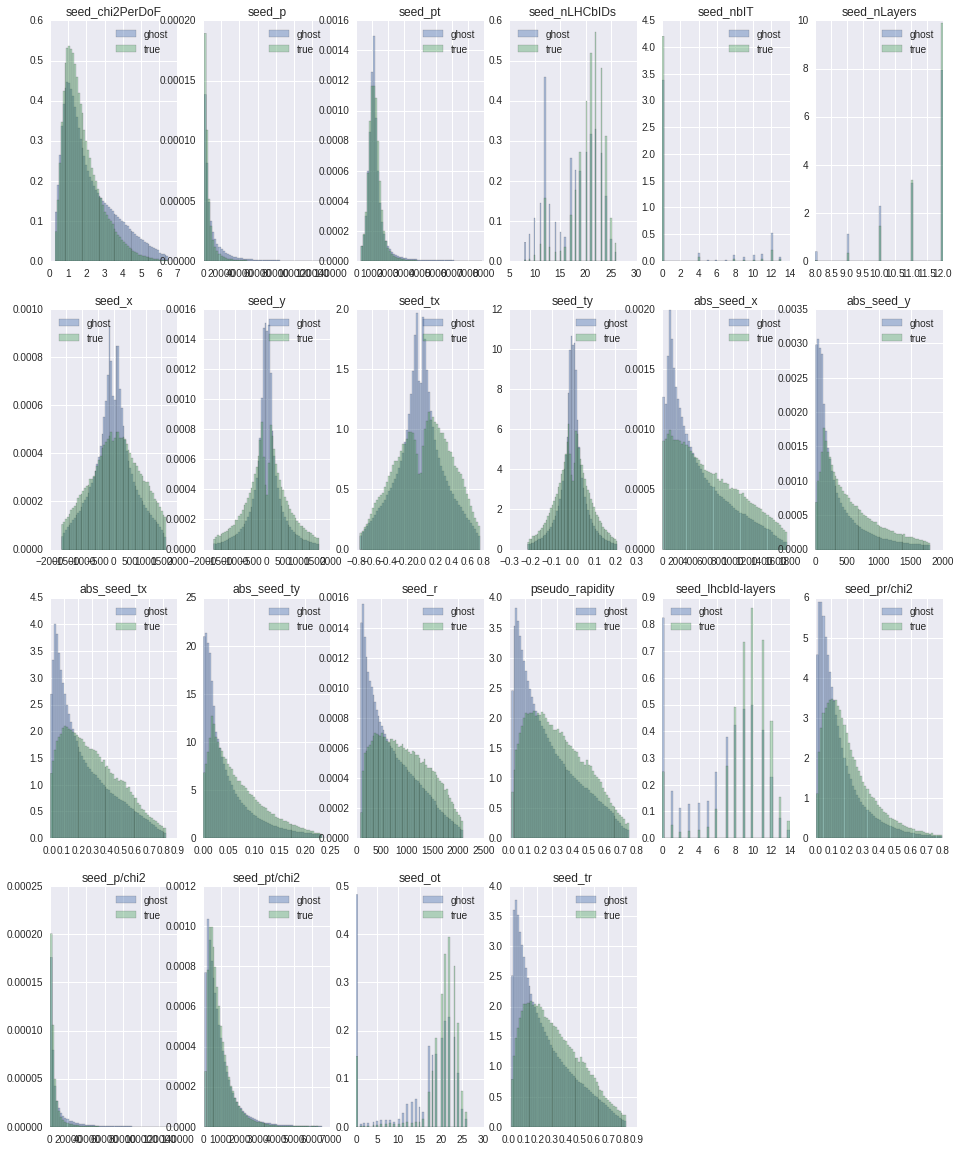

In [41]:
print_features_histograms(linear_features, target)

In [ ]:
linear_trainX, linear_testX, linear_trainY, linear_testY = train_test_split(linear_features, target, random_state=42,train_size=0.5 )
gb_linear= GradientBoostingClassifier(learning_rate=0.2, n_estimators=150, max_depth=6, max_features=8, verbose = 3)
gb_linear.fit(linear_trainX,linear_trainY)
joblib.dump(gb_linear, 'models/BDT_linear.pkl') 

In [25]:
print "ROC AUC score"
roc_auc_score(linear_testY, gb_linear.predict_proba(linear_testX)[:, 1])

ROC AUC score


0.8066236977092156

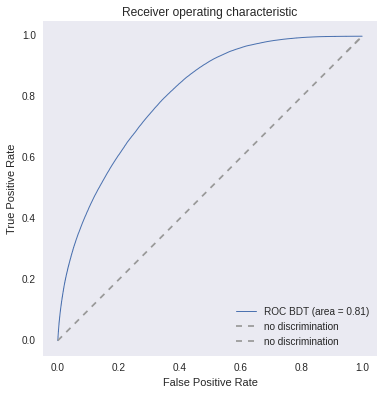

In [26]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(linear_testY, gb_linear.predict_proba(linear_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [29]:
probas = gb_linear.staged_predict_proba(linear_testX)
linear_tree_scores = [] 
for proba in probas:
    predicted = proba[:, 1]
    score =  roc_auc_score(linear_testY, predicted)
    linear_tree_scores.append(score)

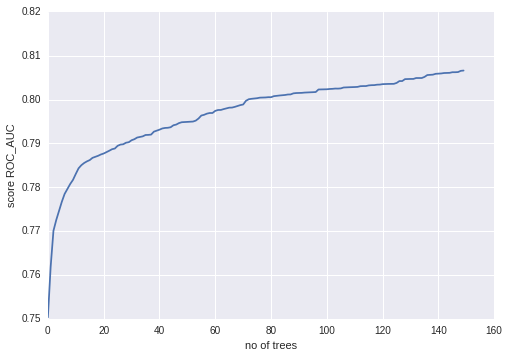

In [31]:
x = numpy.array([x  for x in range(150)])
plt.figure()
plt.plot(x,linear_tree_scores)
plt.ylim(0.75, 0.82)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Now you can go to the next model - BDT base on [XGBoost]( [Logistic Regression](https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/BDT-XGBoost.ipynb) or [Logistic Regression](https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/LogisticRegression.ipynb)    
=========